# CO2 Emission Prediction.
Since 1995, the Government of Canada provides model-specific fuel consumption ratings and estimated carbon dioxide (CO2) emissions for new light-duty vehicles for retail sale in the country. This data can be obtained in the [government website](https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64). 

This project aims to create a model capable of predicting a vehicle's estimated CO2 emission in units of g/km, based on the properties provided in the dataset. The data used is from the years of 2018 to 2022.

# Module Importing and Data Loading
First of all, we are going to import the necessary modules for this project and load the dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

In [2]:
df = pd.read_csv('data/co2_emission.csv')
df.head()

,model year,make,model,vehicle class,engine size (l),cylinders,transmission,fuel type,fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km),co2 rating,smog rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [3]:
print("Number of samples: %.0f" % df.shape[0])
print("Number of features: %.0f" % df.shape[1])

Number of samples: 5003
Number of features: 15


# Data Validation
We need to validate the data and make it analysis-ready.
## Missing Values
Let's begin by checking for missing values:

In [4]:
df.isnull().sum()

model year                          0
make                                0
model                               0
vehicle class                       0
engine size (l)                     0
cylinders                           0
transmission                        0
fuel type                           0
fuel consumption city (l/100 km)    0
fuel consumption hwy (l/100 km)     0
fuel consumption comb (l/100 km)    0
fuel consumption comb (mpg)         0
co2 emissions (g/km)                0
co2 rating                          0
smog rating                         0
dtype: int64

The dataset does not have any missing values.

Following the information on the website, the ``co2 rating`` and the ``smog rating`` features are ratings given to a car after the `co2 emission` is known. Thus, this information cannot be included in our model, as we would like to create a model capable of predicting the CO2 emission of a car based on its features, so are going to remove the ``co2 rating`` and the ``smog rating`` from our analysis.

In [5]:
del df['co2 rating']
del df['smog rating']

Now, let's look at the column types:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5003 entries, 0 to 5002
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   model year                        5003 non-null   int64  
 1   make                              5003 non-null   object 
 2   model                             5003 non-null   object 
 3   vehicle class                     5003 non-null   object 
 4   engine size (l)                   5003 non-null   float64
 5   cylinders                         5003 non-null   int64  
 6   transmission                      5003 non-null   object 
 7   fuel type                         5003 non-null   object 
 8   fuel consumption city (l/100 km)  5003 non-null   float64
 9   fuel consumption hwy (l/100 km)   5003 non-null   float64
 10  fuel consumption comb (l/100 km)  5003 non-null   float64
 11  fuel consumption comb (mpg)       5003 non-null   int64  
 12  co2 em

The `model year` and `cylinder` columns have the `int64` dtype. Let's look at their unique values:

In [7]:
df['model year'].unique()

array([2022, 2021, 2020, 2019, 2018])

In [8]:
df['cylinders'].unique()

array([ 4,  6,  8, 12, 10, 16,  3,  5])

These are actually categorical columns, as these have discrete values. Let's change the column dtype:

In [9]:
df['model year'] = df['model year'].astype(str)
df['cylinders'] = df['cylinders'].astype(str)

df.dtypes()

Now, all the columns have the right dtype. Finally, let's create two lists contaning the name of the numerical and categorical columns.

In [10]:
cat_cols = list(df.loc[:, df.dtypes == object].columns)
num_cols = list(df.loc[:, df.dtypes != object].columns)

# Exploratory Data Analysis
Beforing exploring the data, we are going to split the data into train/validation/test sets, with a 60/20/20% ratio. Then, we follow to analyze the categorical and the numerical features individually.

In [11]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

## Categorical features

Let's look at how many unique values the categorical columns have:

In [12]:
df_train_full[cat_cols].nunique()

model year          5
make               39
model            1326
vehicle class      15
cylinders           8
transmission       26
fuel type           4
dtype: int64

For each column, we are going to analyze their unique values in a barplot and their distribution of CO2 emission via a boxplot. 

### Model Year

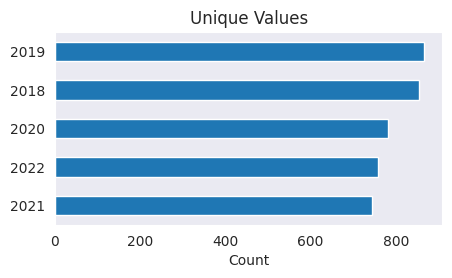

In [13]:
plt.figure(figsize=(5,2.5))
df_train_full['model year'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

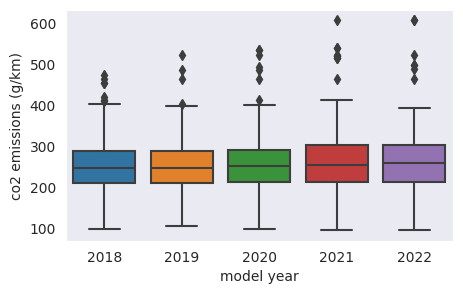

In [14]:
plt.figure(figsize=(5,3))
sns.boxplot(x='model year', 
            y='co2 emissions (g/km)', 
            data=df_train_full.sort_values(by='model year'))
plt.show()

We can see that the CO2 emission has sligthly increased over the years (which is worrying, by the way). 

#### Make
The make column contains information about the car manufacturer.

Unique values in the make column:  39


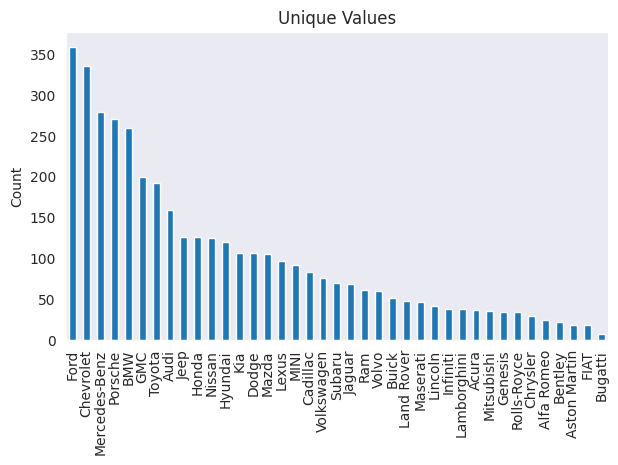

In [15]:
print("Unique values in the make column: ", df_train_full['make'].nunique())
plt.figure(figsize=(7,4))
df_train_full['make'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Ford, Chevrolet, Mercedes-Benz, Porsche and BMW are the top 5 manufacturers. Manufacturer's of luxury cars, such as Lamborghini, Rolls-Royce and Bugatti, have very few samples.

Let's see how is the CO2 emission distribution among the manufacturers.

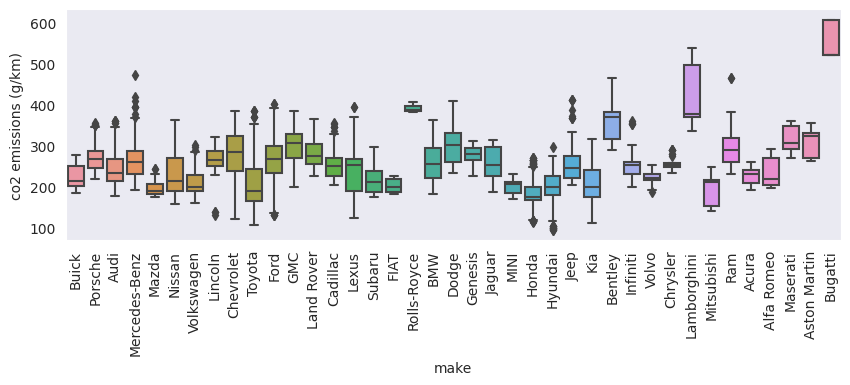

In [16]:
plt.figure(figsize=(10,3))
ax = sns.boxplot(x='make', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The manufacturers present very different distributions of co2 emission. This will be a important feature for our predictions.

Here we can observe some trends:
- Among the cars with the lowest emissions, we find Mazda, Nissan, Toyota, Subaru, Honda and Mitsubishi: all of them are japanese companies. 
- The highest emissions come from manufacturers that produce luxury cars: Rolls-Royce, Bentley, Lamborghini and Bugatti.

### Vehicle Class
Here we have information about the vehicle size (Small, mid-size, compact, etc) and its type (SUV, Pickup truck, van, etc).

Unique values in the vehicle class column:  15


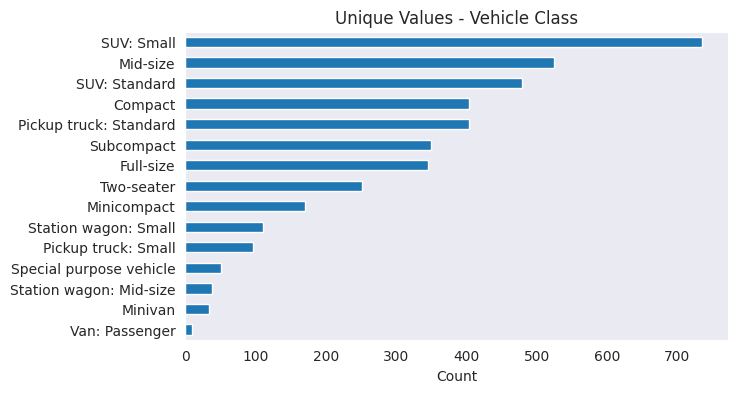

In [17]:
print("Unique values in the vehicle class column: ", df_train_full['vehicle class'].nunique())
plt.figure(figsize=(7,4))
df_train_full['vehicle class'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Vehicle Class')
plt.xlabel('Count')
plt.show()

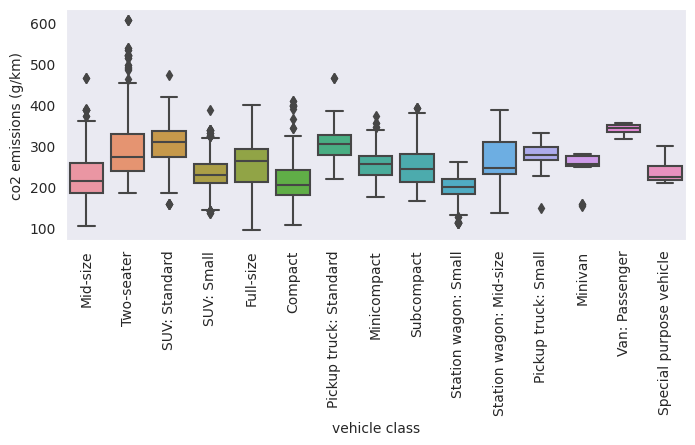

In [18]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='vehicle class', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The compact cars are among those that have the lowest C02 emission rates.

### Cylinders

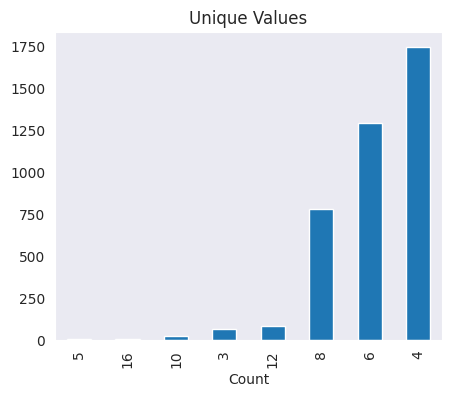

In [19]:
plt.figure(figsize=(5,4))
df_train_full['cylinders'].value_counts().sort_values().plot(kind='bar')
plt.title('Unique Values')
plt.xlabel('Count')
plt.show()

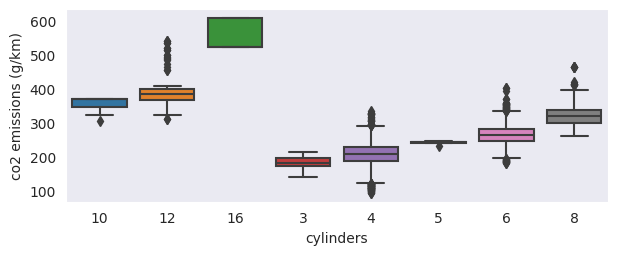

In [20]:
plt.figure(figsize=(7, 2.5))
ax = sns.boxplot(x='cylinders',
                 y='co2 emissions (g/km)', 
                 data=df_train_full.sort_values(by="cylinders"))
plt.show()

Clearly, the CO2 emission rating increases with the cylinders. Thus, this is a very important feature to the model.

### Fuel Type
The fuel type is classified as:

- D = diesel
- E = ethanol (E85)
- X = regular gasoline
- Z = premium gasoline

Unique values in the fuel type column:  4


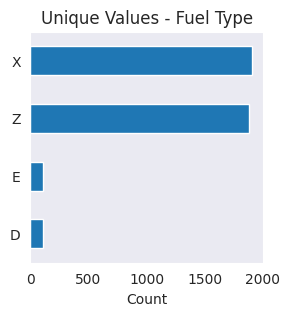

In [21]:
print("Unique values in the fuel type column: ", df_train_full['fuel type'].nunique())
plt.figure(figsize=(3,3))
df_train_full['fuel type'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - Fuel Type')
plt.xlabel('Count')
plt.show()

Most of the cars run by gasoline, with a minority of the running by ethanol and diesel.

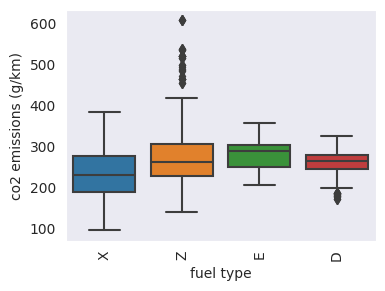

In [22]:
plt.figure(figsize=(4,3))
ax = sns.boxplot(x='fuel type', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

Ethanol and diesel cars have consistently high CO2 emission rates, above 200 g/km for more than 95% of the cars. Cars that run by gasoline present some of the highest emission rates, but also some of the lowest.  
### Transmission
The Transmission is classified as:

- A = automatic
- AM = automated manual
- AS = automatic with select shift
- AV = continuously variable
- M = manual

Unique values in the transmission column:  26


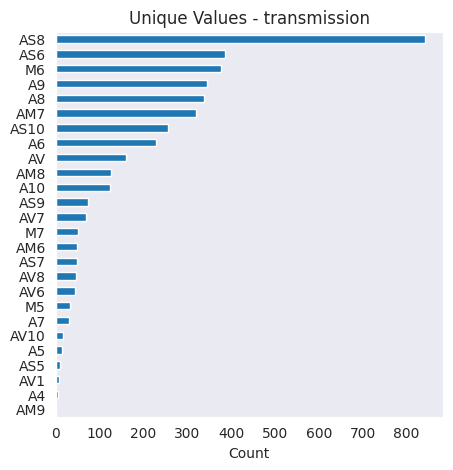

In [23]:
print("Unique values in the transmission column: ", df_train_full['transmission'].nunique())
plt.figure(figsize=(5,5))
df_train_full['transmission'].value_counts().sort_values().plot(kind='barh')
plt.title('Unique Values - transmission')
plt.xlabel('Count')
plt.show()

Most cars have automatic transmissions, with the automatic select shift (AS) being the most frequent. However, the M6 ​​transmission is the third most frequent, showing that manual cars still have a large share of the market. 

Let's check the CO2 emission for the transmissions:

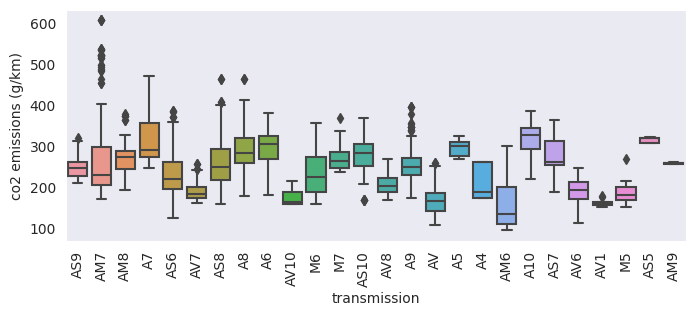

In [24]:
plt.figure(figsize=(8,3))
ax = sns.boxplot(x='transmission', 
                 y='co2 emissions (g/km)', 
                 data=df_train_full)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The highest emissions are among the fully automatic cars (A). The continuously variable (AV) have the lowest CO2 emission ratios. For manual cars, the M5 transmission have low emission rate, whereas the M7 shows high rate and the M6 has a high variance between its samples.

### Model
The model column has many unique values:

In [25]:
df_train_full['model'].nunique()

1326

This column contains 1326 unique values. 

Unique values in the model column:  1326


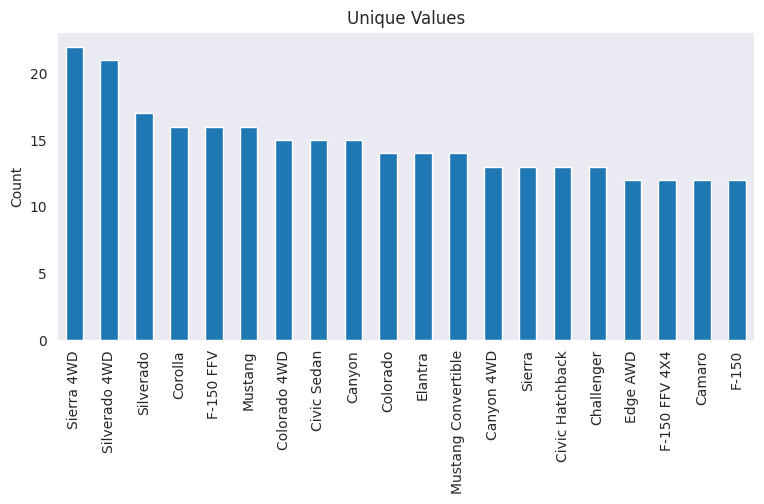

In [26]:
print("Unique values in the model column: ", df_train_full['model'].nunique())
plt.figure(figsize=(9,4))
df_train_full['model'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Unique Values')
plt.ylabel('Count')
plt.show()

Let's look at the CO2 emission of the first 20 models about the first 20

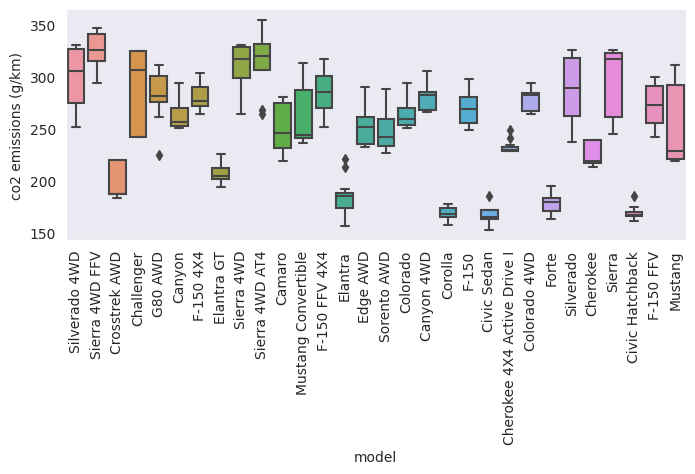

In [27]:
mask = df_train_full['model'].isin(list(df_train_full['model'].value_counts().head(30).index))
top_models = df_train_full[mask]

plt.figure(figsize=(8,3))
ax = sns.boxplot(x='model', 
                 y='co2 emissions (g/km)', 
                 data=top_models)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The distribution of CO2 emission is very different between the car models. However, the high number of unique values can make the model to overfit. Thus, this is a feature that probably will be removed from the dataset in order to train it. 

## Numerical Features
Now, let's look at the numerical features and their relations with the CO2 emission rating.

- Fuel consumption:	City and highway fuel consumption ratings are shown in litres per 100 kilometres (L/100 km) - the combined rating (55% city, 45% hwy) is shown in L/100 km and in miles per imperial gallon (mpg).

### Correlations
First, let's look at the correlations between the features.

In [28]:
num_cols

['engine size (l)',
 'fuel consumption city (l/100 km)',
 'fuel consumption hwy (l/100 km)',
 'fuel consumption comb (l/100 km)',
 'fuel consumption comb (mpg)',
 'co2 emissions (g/km)']

In [29]:
df_train_full[num_cols].corr()

,engine size (l),fuel consumption city (l/100 km),fuel consumption hwy (l/100 km),fuel consumption comb (l/100 km),fuel consumption comb (mpg),co2 emissions (g/km)
engine size (l),1.000000,0.837142,0.757712,0.822162,-0.723847,0.833662
fuel consumption city (l/100 km),0.837142,1.000000,0.933221,0.992027,-0.911873,0.949557
fuel consumption hwy (l/100 km),0.757712,0.933221,1.000000,0.970715,-0.886318,0.916930
fuel consumption comb (l/100 km),0.822162,0.992027,0.970715,1.000000,-0.917156,0.952956
fuel consumption comb (mpg),-0.723847,-0.911873,-0.886318,-0.917156,1.000000,-0.906536
co2 emissions (g/km),0.833662,0.949557,0.916930,0.952956,-0.906536,1.000000


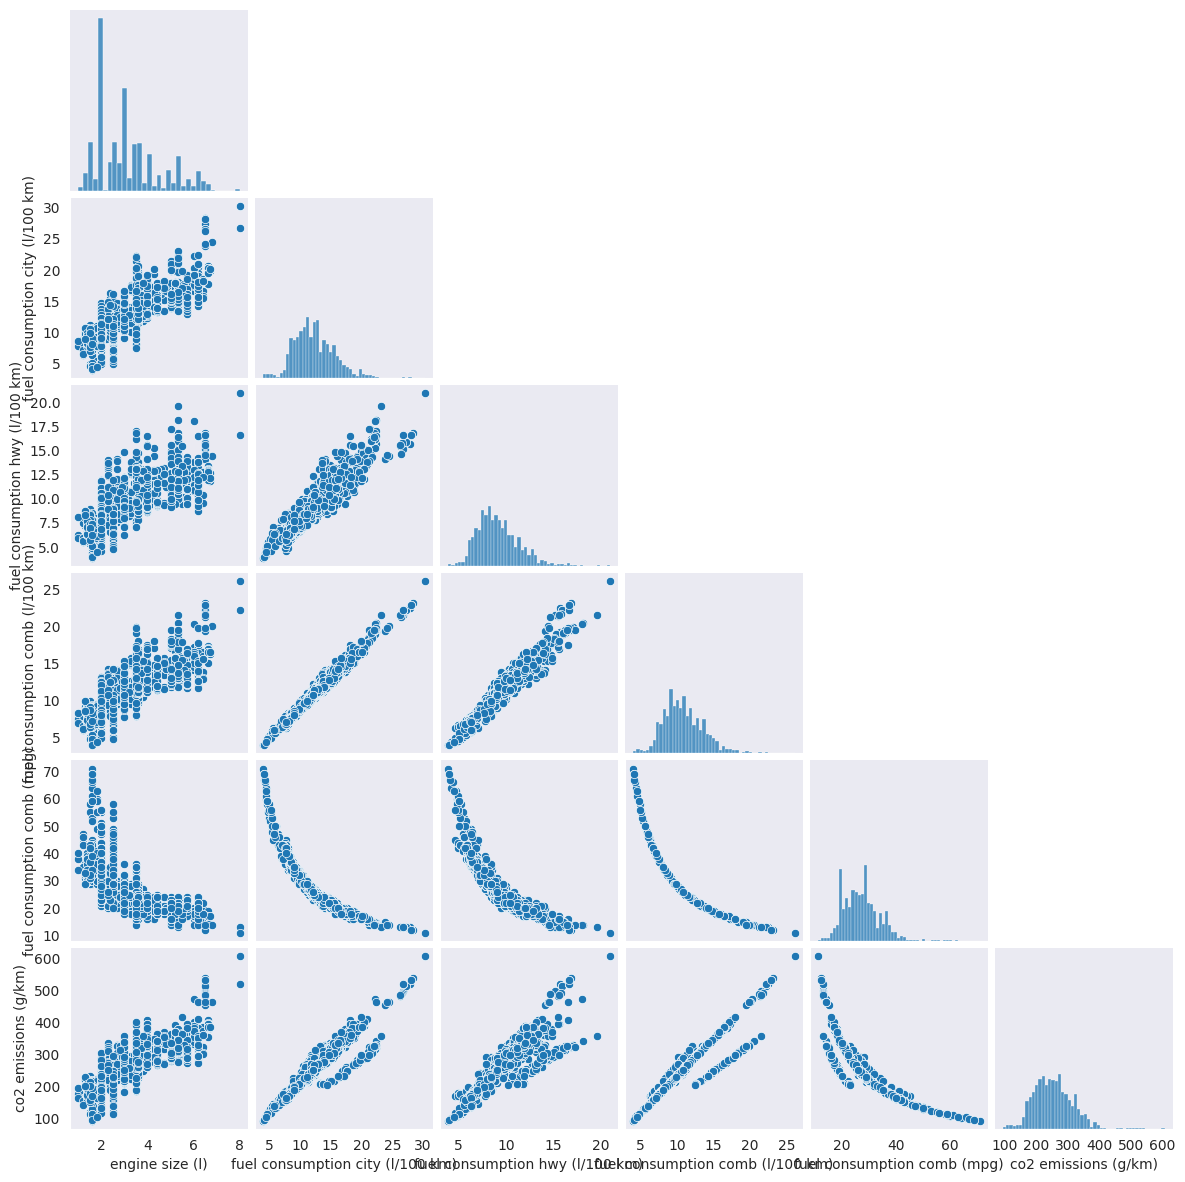

In [30]:
sns.pairplot(df_train_full[num_cols], height=2, corner=True)
sns.set(font_scale=0.6)
plt.show()

We

In [62]:
# Creating target series
y_train = df_train['co2 emissions (g/km)']
y_val = df_val['co2 emissions (g/km)']

# Removing target from train sets
drop_cols = ['co2 emissions (g/km)']
# drop_cols = ['co2 emissions (g/km)', 
#              'fuel consumption city (l/100 km)', 
#              'fuel consumption hwy (l/100 km)',
#              'fuel consumption comb (l/100 km)', 
#              'fuel consumption comb (mpg)', 
#              'model'
#             ]

X_train = df_train.drop(drop_cols, axis=1)
X_val = df_val.drop(drop_cols, axis=1)

X_cat_cols = list(X_train.loc[:, X_train.dtypes == object].columns)
X_num_cols = list(X_train.loc[:, X_train.dtypes != object].columns)

# Model Fitting
Before make some experiments, we are going to create a pipeline to help us fit the models. 

Our approach will be training a linear and a tree-based model, and compare both performances. We are going to follow these steps:
- First, we will train a Linear Regression model using just the numerical values. This will be our baseline model: everything that follows must improve the results obtained here.
- Then, we are going to use Ridge Regression as our linear model.
- Finally, we will fit a Random Forest Regressor as our ensemble model.

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def make_pipeline(model, df):
    """Create a pipeline for a model."""

    cat_transf = OneHotEncoder(sparse=False,
                               handle_unknown="ignore")

    std_scaler = StandardScaler()

    # Determining categorical and numerical columns
    X_cat_cols = list(df.loc[:, df.dtypes == object].columns)
    X_num_cols = list(df.loc[:, df.dtypes != object].columns)

    transformer = ColumnTransformer(transformers=[("cat", cat_transf, X_cat_cols),
                                                  ("num_scaler", std_scaler, X_num_cols)],
                                    remainder='passthrough'
                                   )

    steps = [("transformer", transformer),
             ("model", model)]
    
    return Pipeline(steps)

Finally, let's create a DataFrame to store all the results.

In [218]:
final_scores = pd.DataFrame({"Model": [], 
                             "Dataset": [], 
                             "Score":[]})

## Baseline Model
First, we will create a dataset containing only numerical features, and train a Linear Regression model to serve as baseline. 

In [49]:
X_train_num = df_train[X_num_cols]
X_val_num = df_val[X_num_cols]

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lrg = LinearRegression()

pipe_lrg = make_pipeline(lrg, X_train_num) 

pipe_lrg.fit(X_train_num, y_train)

y_pred_train = pipe_lrg.predict(X_train_num)
y_pred_val = pipe_lrg.predict(X_val_num)

lrg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
lrg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(lrg_score_train))
print("RMSE Validation = {:0.3f}".format(lrg_score_val))

RMSE Train = 17.609
RMSE Validation = 18.047


## Ridge Regression
Now, we will train a Ridge Regression model. Let's use a list of alpha values and check which one gives the best results.

In [53]:
from sklearn.linear_model import Ridge

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    rdg = Ridge(alpha=alpha)

    pipe_rdg = make_pipeline(rdg, X_train)

    pipe_rdg.fit(X_train, y_train)

    y_pred_train = pipe_rdg.predict(X_train)
    y_pred_val = pipe_rdg.predict(X_val)

    rdg_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rdg_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    print("Alpha: ", alpha)
    print("RMSE Train = {:0.3f}".format(rdg_score_train))
    print("RMSE Validation = {:0.3f}".format(rdg_score_val))

Alpha:  0.001
RMSE Train = 2.851
RMSE Validation = 2.738
Alpha:  0.01
RMSE Train = 2.851
RMSE Validation = 2.738
Alpha:  0.1
RMSE Train = 2.851
RMSE Validation = 2.740
Alpha:  1
RMSE Train = 2.868
RMSE Validation = 2.779
Alpha:  10
RMSE Train = 3.775
RMSE Validation = 3.839
Alpha:  100
RMSE Train = 10.732
RMSE Validation = 10.962


The best alpha is `alpha=0.001`, with `RMSE = 2.869` on train dataset and `2.750` on the validation dataset. These are good scores, and the model is not overfitting.

### Performance on test data
Now that we saw how the alpha parameter affect the performance, we are going to train the model in the full train dataset (train + validation) using Cross Validation and Grid Search to search for the best parameter. Finally, we are going to test it on our holdout test dataset.  

First, we create the full train and the test datasets:

In [63]:
y_train_full = df_train_full['co2 emissions (g/km)']
y_test = df_test['co2 emissions (g/km)']

X_train_full = df_train_full[X_cat_cols + X_num_cols]
X_test = df_test[X_cat_cols + X_num_cols]

Now, we retrain the, using GridSearchCV with 5-fold cross validation, and `neg_root_mean_squared_error` as our scoring method:

In [219]:
from sklearn.model_selection import GridSearchCV

rdg_final = Ridge()
pipe_rdg_final = make_pipeline(rdg_final, X_train_full)

param_grid_rdg = {'model__alpha': alpha_list}

gs_cv_rdg = GridSearchCV(pipe_rdg_final, param_grid_rdg,
                         scoring='neg_root_mean_squared_error', cv=5)

gs_cv_rdg.fit(X_train_full, y_train_full)

y_pred_train_full = gs_cv_rdg.predict(X_train_full)
y_pred_test = gs_cv_rdg.predict(X_test)

rdg_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rdg_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

rdg_results = pd.DataFrame({"Model": ["Ridge"] * 2,
                            "Dataset": ["Train", "Test"],
                            "Score": [rdg_score_train_full, rdg_score_test]
                           })

final_scores = pd.concat([final_scores, rdg_results])

print("RMSE Train = {:0.3f}".format(rdg_score_train_full))
print("RMSE Test = {:0.3f}".format(rdg_score_test))
print(gs_cv_rdg.best_params_)

RMSE Train = 1.990
RMSE Test = 2.296
{'model__alpha': 1}


## Random Forest Regressor
Now, we will train a Random Forest Regressor as our tree-based model. First, we are going to assess the influence of the number of trees in the model parameter. Then, analyze how the `max_depth`, `min_samples_leaf` and `` parameters affect the RMSE.

In [102]:
from sklearn.ensemble import RandomForestRegressor

num_trees = [10, 20, 50, 100, 200, 300]

rmses = []
for n in num_trees:

    rfr = RandomForestRegressor(n_estimators=n, random_state=3)
    pipe_rfr = make_pipeline(rfr, X_train)

    pipe_rfr.fit(X_train, y_train)

    y_pred = pipe_rfr.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.3f' % (n, rmse_val))

    rmses.append(rmse_val)

 10 -> 3.962
 20 -> 4.004
 50 -> 3.246
100 -> 3.138
300 -> 3.112
500 -> 3.188


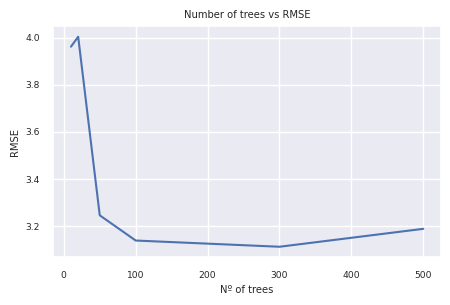

In [105]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses)
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.title('Number of trees vs RMSE')
plt.show()

After 300 trees, the RMSE on validation data starts to increase. 

Now, we evaluate the performance for different values of the `max_depth` parameter.

In [106]:
all_rmses_depth = {}
depth_list = [5, 10, 20, None]

for depth in depth_list:
    print('max_depth: %s' % depth)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees, 
                                    max_depth=depth, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr, X_train)

        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_depth[depth] = rmses

max_depth: 5
 10 -> 7.590
 20 -> 7.593
 50 -> 7.371
100 -> 7.372
300 -> 7.260
500 -> 7.278

max_depth: 10
 10 -> 3.469
 20 -> 4.016
 50 -> 3.494
100 -> 3.262
300 -> 3.235
500 -> 3.263

max_depth: 20
 10 -> 3.799
 20 -> 3.913
 50 -> 3.245
100 -> 3.186
300 -> 3.162
500 -> 3.231

max_depth: None
 10 -> 3.962
 20 -> 4.004
 50 -> 3.246
100 -> 3.138
300 -> 3.112
500 -> 3.188



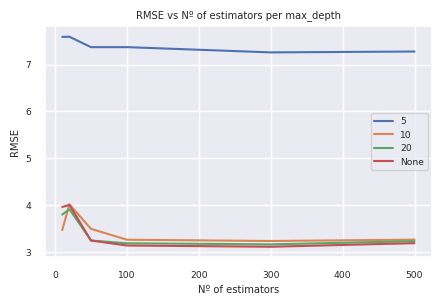

In [108]:
plt.figure(figsize=(5,3))
for depth in depth_list:
    if depth == None:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label="None")
    else:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label=depth)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

`max_depth=5` yields really bad results. Let's zoom the plot on the 10, 20 and None values.

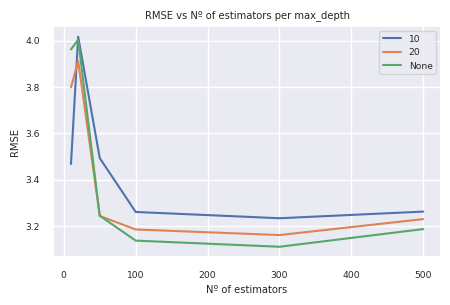

In [109]:
plt.figure(figsize=(5,3))
for depth in [10,20,None]:
    if depth == None:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label="None")
    else:
        plt.plot(num_trees, all_rmses_depth[depth], '-', label=depth)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

The best RMSE is reached when `max_depth=None`. Let's fix this paramter and assess the effect of the `min_samples_leaf` parameter.

In [110]:
all_rmses_leaf = {}
leaf_list = [1, 2, 3, 4]

for leaf in leaf_list:
    print('min_samples_leaf: %s' % leaf)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees,
                                    max_depth=None, 
                                    min_samples_leaf=leaf, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr, X_train)
        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_leaf[leaf] = rmses

min_samples_leaf: 1
 10 -> 3.962
 20 -> 4.004
 50 -> 3.246
100 -> 3.138
300 -> 3.112
500 -> 3.188

min_samples_leaf: 2
 10 -> 3.799
 20 -> 4.223
 50 -> 3.741
100 -> 3.572
300 -> 3.533
500 -> 3.548

min_samples_leaf: 3
 10 -> 4.214
 20 -> 4.506
 50 -> 3.937
100 -> 3.842
300 -> 3.833
500 -> 3.854

min_samples_leaf: 4
 10 -> 4.242
 20 -> 4.728
 50 -> 4.167
100 -> 4.036
300 -> 4.027
500 -> 4.049



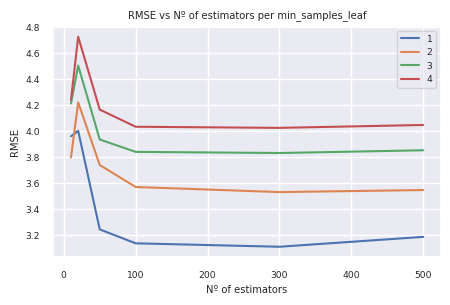

In [112]:
plt.figure(figsize=(5,3))
for leaf in leaf_list:
    plt.plot(num_trees, all_rmses_leaf[leaf], '-', label=leaf)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per min_samples_leaf')
plt.show()

The best result is with `min_samples_leaf = 1`. 

In [113]:
all_rmses_split = {}
split_list = [2, 4, 6, 8]

for split in split_list:
    print('min_samples_split: %s' % split)

    rmses = []
    for trees in num_trees:
        rfr = RandomForestRegressor(n_estimators=trees,
                                    max_depth=None,
                                    min_samples_leaf=1, 
                                    min_samples_split=split, 
                                    random_state=3)
        pipe_rfr = make_pipeline(rfr, X_train)
        pipe_rfr.fit(X_train, y_train)

        y_pred = pipe_rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_split[split] = rmses

min_samples_split: 2
 10 -> 3.962
 20 -> 4.004
 50 -> 3.246
100 -> 3.138
300 -> 3.112
500 -> 3.188

min_samples_split: 4
 10 -> 3.714
 20 -> 4.306
 50 -> 3.440
100 -> 3.245
300 -> 3.233
500 -> 3.273

min_samples_split: 6
 10 -> 3.871
 20 -> 4.032
 50 -> 3.394
100 -> 3.309
300 -> 3.342
500 -> 3.350

min_samples_split: 8
 10 -> 3.844
 20 -> 4.175
 50 -> 3.577
100 -> 3.448
300 -> 3.454
500 -> 3.459



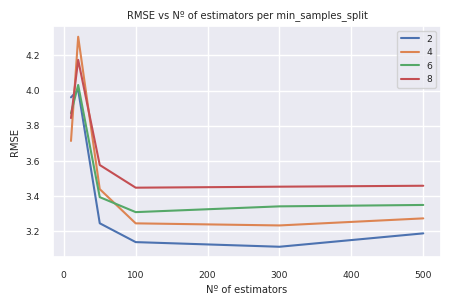

In [117]:
plt.figure(figsize=(5,3))
for split in split_list:
    plt.plot(num_trees, all_rmses_split[split], '-', label=split)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE vs Nº of estimators per min_samples_split')
plt.show()

### Test Data

In [222]:
rfr_final = RandomForestRegressor(n_estimators=200, 
                                  max_depth=10, 
                                  min_samples_leaf=1,
                                  min_samples_split=4,
                                  random_state=3)

pipe_rfr_final = make_pipeline(rfr_final, X_train_full)

pipe_rfr_final.fit(X_train_full, y_train_full)

y_pred_train_full = pipe_rfr_final.predict(X_train_full)
y_pred_test = pipe_rfr_final.predict(X_test)

rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

rfr_results = pd.DataFrame({"Model": ["Random Forest"] * 2,
                            "Dataset": ["Train", "Test"],
                            "Score": [rfr_score_train_full, rfr_score_test]
                           })

final_scores = pd.concat([final_scores, rfr_results])

print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
print("RMSE Test = {:0.3f}".format(rfr_score_test))

RMSE Train = 1.223
RMSE Test = 1.758


In [123]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

pipe_rfr_cv = make_pipeline(rfr, X_train)

param_grid_rfr = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__min_samples_leaf': leaf_list,
    'model__min_samples_split': split_list,
}

rs_cv_rfr = RandomizedSearchCV(estimator = pipe_rfr_cv,
                               param_distributions = param_grid_rfr,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs = 4)

rs_cv_rfr.fit(X_train, y_train)

y_pred_train = rs_cv_rfr.predict(X_train)
y_pred_val = rs_cv_rfr.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("RMSE Train = {:0.3f}".format(rfr_score_train))
print("RMSE val = {:0.3f}".format(rfr_score_val))
print(rs_cv_rfr.best_params_)

RMSE Train = 1.739
RMSE val = 3.573
{'model__n_estimators': 10, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 10}


In [122]:
from sklearn.model_selection import RandomizedSearchCV

rfr = RandomForestRegressor()

pipe_rfr_cv = make_pipeline(rfr, X_train_full)

param_grid_rfr = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__min_samples_leaf': leaf_list,
    'model__min_samples_split': split_list,
}

rs_cv_rfr = RandomizedSearchCV(estimator = pipe_rfr_cv,
                               param_distributions = param_grid_rfr,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs = 4)

rs_cv_rfr.fit(X_train_full, y_train_full)

y_pred_train_full = rs_cv_rfr.predict(X_train_full)
y_pred_test = rs_cv_rfr.predict(X_test)

rfr_score_train_full = np.sqrt(mean_squared_error(y_train_full, y_pred_train_full))
rfr_score_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE Train = {:0.3f}".format(rfr_score_train_full))
print("RMSE Test = {:0.3f}".format(rfr_score_test))
print(rs_cv_rfr.best_params_)

RMSE Train = 1.451
RMSE Test = 1.783
{'model__n_estimators': 10, 'model__min_samples_split': 4, 'model__min_samples_leaf': 1, 'model__max_depth': 10}


## XGBoost Regressor

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor(random_state=5)

pipe_xgb = make_pipeline(model_xgb, X_train_full)

pipe_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = pipe_xgb.predict(X_train_full)
pred_test_xgb = pipe_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

RMSE Train = 1.114
RMSE Test = 1.887


In [131]:
num_trees = [10, 20, 50, 100, 200]

rmses_train = []
rmses_val = []
for n in num_trees:

    model_xgb = XGBRegressor(n_estimators=n, random_state=5)

    pipe_xgb = make_pipeline(model_xgb, X_train)

    pipe_xgb.fit(X_train, y_train)

    y_pred_train = pipe_xgb.predict(X_train)
    y_pred_val = pipe_xgb.predict(X_val)


    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print('%3s -> train: %.3f / val: %.3f' % (n, rmse_train, rmse_val))

    rmses_train.append(rmse_train)
    rmses_val.append(rmse_val)

 10 -> train: 8.187 / val: 8.866
 20 -> train: 1.829 / val: 3.132
 50 -> train: 1.453 / val: 2.934
100 -> train: 1.112 / val: 2.812
200 -> train: 0.827 / val: 2.717


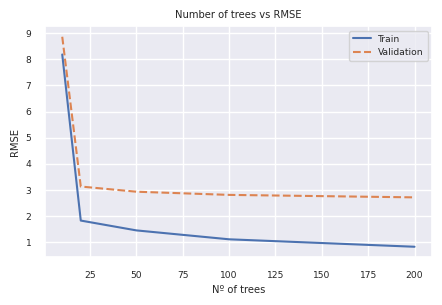

In [141]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses_train, label="Train")
plt.plot(num_trees, rmses_val, linestyle='--', label="Validation")
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.legend()
plt.title('Number of trees vs RMSE')
plt.show()

In [159]:
xgb_rmses_train_depth = {}
xgb_rmses_val_depth = {}

depth_list = [3, 5, 7, 9]

for depth in depth_list:
    print('max_depth: %s' % depth)

    rmses_train = []
    rmses_val = []
    for trees in num_trees:
        xgb = XGBRegressor(n_estimators=trees, 
                           max_depth=depth, 
                           random_state=3)

        pipe_xgb = make_pipeline(xgb, X_train)

        pipe_xgb.fit(X_train, y_train)

        y_pred_train = pipe_xgb.predict(X_train)
        y_pred_val = pipe_xgb.predict(X_val)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

        print('%3s -> train: %.3f / val: %.3f' % (trees, rmse_train, rmse_val))

        rmses_train.append(rmse_train)
        rmses_val.append(rmse_val)

    
    print()

    xgb_rmses_train_depth[depth] = rmses_train
    xgb_rmses_val_depth[depth] = rmses_val

max_depth: 3
 10 -> train: 9.247 / val: 9.944
 20 -> train: 3.345 / val: 4.287
 50 -> train: 2.570 / val: 3.584
100 -> train: 2.068 / val: 3.248
200 -> train: 1.632 / val: 2.984

max_depth: 5
 10 -> train: 8.213 / val: 8.870
 20 -> train: 2.035 / val: 3.225
 50 -> train: 1.620 / val: 2.995
100 -> train: 1.311 / val: 2.863
200 -> train: 1.036 / val: 2.765

max_depth: 7
 10 -> train: 8.176 / val: 8.858
 20 -> train: 1.610 / val: 3.048
 50 -> train: 1.272 / val: 2.867
100 -> train: 0.976 / val: 2.769
200 -> train: 0.723 / val: 2.698

max_depth: 9
 10 -> train: 8.172 / val: 8.853
 20 -> train: 1.334 / val: 3.003
 50 -> train: 0.930 / val: 2.836
100 -> train: 0.714 / val: 2.788
200 -> train: 0.517 / val: 2.750



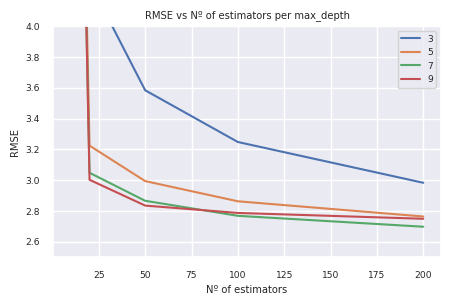

In [168]:
plt.figure(figsize=(5,3))
for depth in depth_list:
    plt.plot(num_trees, xgb_rmses_val_depth[depth], '-', label=str(depth))
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.ylim([2.5, 4])
plt.legend()
plt.title('RMSE vs Nº of estimators per max_depth')
plt.show()

`max_depth=7` yields the best RMSE. Fixing this parameter, let's find the best `eta`:

In [171]:
xgb_rmses_train_eta = {}
xgb_rmses_val_eta = {}

eta_list = [0.1, 0.2, 0.3, 0.5]
for eta in eta_list:
    print('eta: %s' % eta)

    rmses_train = []
    rmses_val = []
    for trees in num_trees:
        xgb = XGBRegressor(n_estimators=trees,
                           max_depth=7,
                           eta = eta,
                           random_state=3)

        pipe_xgb = make_pipeline(xgb, X_train)

        pipe_xgb.fit(X_train, y_train)

        y_pred_train = pipe_xgb.predict(X_train)
        y_pred_val = pipe_xgb.predict(X_val)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

        print('%3s -> train: %.3f / val: %.3f' % (trees, rmse_train, rmse_val))

        rmses_train.append(rmse_train)
        rmses_val.append(rmse_val)

    
    print()

    xgb_rmses_train_eta[eta] = rmses_train
    xgb_rmses_val_eta[eta] = rmses_val

eta: 0.1
 10 -> train: 91.609 / val: 92.714
 20 -> train: 32.432 / val: 32.996
 50 -> train: 2.087 / val: 3.480
100 -> train: 1.093 / val: 2.901
200 -> train: 0.911 / val: 2.857

eta: 0.2
 10 -> train: 28.771 / val: 29.312
 20 -> train: 3.753 / val: 4.541
 50 -> train: 1.194 / val: 2.598
100 -> train: 1.032 / val: 2.567
200 -> train: 0.831 / val: 2.520

eta: 0.3
 10 -> train: 8.176 / val: 8.858
 20 -> train: 1.610 / val: 3.048
 50 -> train: 1.272 / val: 2.867
100 -> train: 0.976 / val: 2.769
200 -> train: 0.723 / val: 2.698

eta: 0.5
 10 -> train: 2.027 / val: 4.170
 20 -> train: 1.514 / val: 3.972
 50 -> train: 1.063 / val: 3.867
100 -> train: 0.709 / val: 3.793
200 -> train: 0.451 / val: 3.770



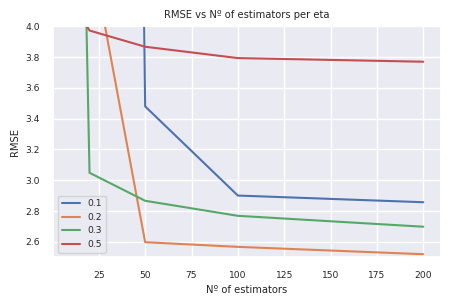

In [174]:
plt.figure(figsize=(5,3))
for eta in eta_list:
    plt.plot(num_trees, xgb_rmses_val_eta[eta], '-', label=eta)
plt.xlabel('Nº of estimators')
plt.ylabel('RMSE')
plt.ylim([2.5, 4])
plt.legend()
plt.title('RMSE vs Nº of estimators per eta')
plt.show()

The best `eta` is 0.2. 
### Test

In [176]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor()

pipe_xgb = make_pipeline(model_xgb, X_train_full)

param_grid_xgb = {
    'model__max_depth': depth_list,
    'model__n_estimators': num_trees,
    'model__eta':  eta_list,
}

rs_cv_xgb = RandomizedSearchCV(estimator = pipe_xgb,
                               param_distributions = param_grid_xgb,
                               n_iter=30, cv=5,
                               verbose=0, scoring='neg_root_mean_squared_error',
                               random_state=3, n_jobs=-1)

rs_cv_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = rs_cv_xgb.predict(X_train_full)
pred_test_xgb = rs_cv_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

KeyboardInterrupt: 

In [223]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=200, 
                         max_depth=7,
                         eta=0.2, 
                         random_state=3)

pipe_xgb = make_pipeline(model_xgb, X_train_full)

pipe_xgb.fit(X_train_full, y_train_full)

pred_train_full_xgb = pipe_xgb.predict(X_train_full)
pred_test_xgb = pipe_xgb.predict(X_test)

xgb_score_train_full = np.sqrt(mean_squared_error(y_train_full, pred_train_full_xgb))
xgb_score_test = np.sqrt(mean_squared_error(y_test, pred_test_xgb))

xgb_results = pd.DataFrame({"Model": ["XGBoost"] * 2,
                            "Dataset": ["Train", "Test"],
                            "Score": [xgb_score_train_full, xgb_score_test]
                           })

final_scores = pd.concat([final_scores, xgb_results])

print("RMSE Train = {:0.3f}".format(xgb_score_train_full))
print("RMSE Test = {:0.3f}".format(xgb_score_test))

RMSE Train = 0.872
RMSE Test = 1.609


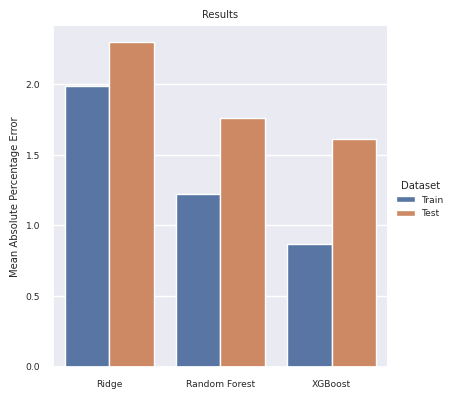

In [240]:
sns.catplot(x='Model', y='Score', data=final_scores, hue='Dataset', kind='bar', aspect=1, height=4)
plt.title('Results')
plt.xlabel('')
plt.ylabel('Mean Absolute Percentage Error')
plt.show()

The XGBoost model has the best performance.

## Feature Engineering

Now, let's try some feature engineering to avoid overfitting.  

# Conclusion

The best model is XGBoost Regressor!